# Aprendizaje de Máquina - Proyecto Final
## Ciro Iván García López


Librerias necesarias para la lectura y manejo de los datos.
- pandas : encargada de construir, leer y manipular el conjunto de datos.
- numpy : se encarga del casteo de tipos, es decir convertir todo a float64.
- mathplotlib : permite generar gráficas a partir de un conjunto de datos. 
- seaborn : permite generar el mapa de calor para la correlación de los datos.
- scipy : libreria de herramientas estadisticas. 
- sklearn : libreria de herramientas para aprendizaje. 
- keras : librería para el manejo de redes neuronales

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.polynomial.polynomial as poly
import keras
import math

from sklearn.linear_model import Lasso
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.utils import to_categorical
from numpy.random import seed
from numpy.random import randn
seed(1)


Funciones auxiliares para la creación de DataFrames
- dfBuild : construye un DataFrame dado un arreglo
- dfBuildIny : construye un DataFrame dado un arreglo($dt$) y una potencia($n$), el dataframe resultante tendrá la forma: $dt | dt^2 | ... | dt^n $

In [3]:
def dfBuild(dt):
    return pd.DataFrame(data={"x1":dt})

def dfBuildIny(dt,t):
    df = pd.DataFrame()
    for i in range(0,t):
        s = "x"+str(i+1)
        df.insert(i,s,dt**(i+1))
    return df

Funciones auxiliares que calculan los valores de RSS y AIC, versión polinomial y por predicción.

In [4]:
def getRA(x, y, model,M):
    RSS = 0.5*np.sum((y-model(x))**2)
    AIC = len(x)*math.log10(RSS/len(x))+ 2*M*len(x)/(len(x)-M-1)
    return RSS,AIC

def getRAP(x, y, model,M):
    RSS = 0.5*np.sum( (y-model.predict(dfBuildIny(x,M)))**2 )
    AIC = len(x)*math.log10(RSS/len(x))+ 2*M*len(x)/(len(x)-M-1)
    return RSS,AIC

## Punto 1

### Lectura y preparación de los datos.
Se hace la lectura de los datos así como la preparación de los mismos. Para este problema tanto los datos de entrenamiento como de validación se encuentran en el archivo *problem1.csv*.

In [6]:
archivoUno = 'problem1.csv'
datosUno = pd.read_csv(archivoUno)
datosUno.head(3)

,X_training,Y_training,X_test,Y_test
0,-2.00,22.067387,2.00,6.024049
1,-1.97,19.944915,2.05,6.885408
2,-1.94,18.062490,2.10,7.578968


Se crean los Dataframe para las regresiones Lasso y Polynomial. Se comienza creando los Dataframe para los datos de entrenamiento.

In [7]:
#Datos originales para x, en arreglo
xTrainUno = datosUno["X_training"]
yTrainUno = datosUno["Y_training"]
xTrainUno.head(3)

0   -2.00
1   -1.97
2   -1.94
Name: X_training, dtype: float64

Dataframe para los datos de validación. Observe la intrucción *dropna*; la lectura del archivo introduce estos valores, pero no hacen parte del archivo de datos csv.

In [8]:
#Datos originales para x, en arreglo
xTestUno = datosUno["X_test"].dropna()
yTestUno = datosUno["Y_test"].dropna()
xTestUno.head(3)

0    2.00
1    2.05
2    2.10
Name: X_test, dtype: float64

### Gráfica de los datos. 

Se grafican los datos para conocer su comportamiento.

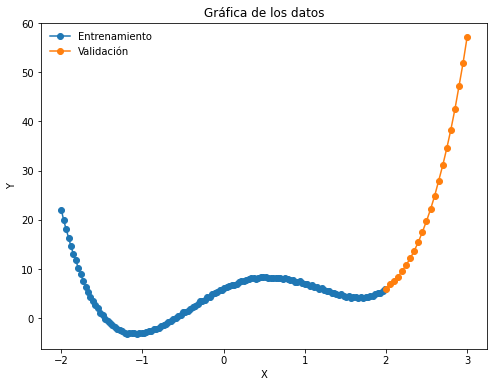

In [9]:
plt.figure(figsize=(8, 6))
plt.title("Gráfica de los datos")
plt.plot(xTrainUno, yTrainUno, '-o', label="Entrenamiento")
plt.plot(xTestUno,yTestUno, '-o', label="Validación")
plt.ylabel("Y")
plt.xlabel("X")
plt.legend(loc='best', frameon=False)
plt.show()

### Regresión usando Polyfit

Se procede a hacer una regresión de los datos usando Polyfit

In [218]:
coefUno = poly.polyfit(xTrainUno, yTrainUno, 3)
modelUno = poly.Polynomial(coefUno)
modelUno

Polynomial([ 3.20942252,  8.09866596,  0.91824065, -3.04861233], domain=[-1,  1], window=[-1,  1])

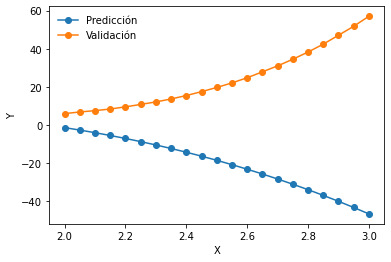

In [219]:
plt.plot(xTestUno, modelUno(xTestUno),'-o', label='Predicción')
plt.plot(xTestUno, yTestUno,'-o', label='Validación')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='best', frameon=False)
plt.show()

### AIC

In [220]:
Pol_Max = 15
RSSv = np.zeros(Pol_Max-4)
AICv = np.zeros(Pol_Max-4)

for i in np.arange(4,Pol_Max,1):
    coef = poly.polyfit(xTrainUno, yTrainUno, i)
    model = poly.Polynomial(coef)
    rt, at = getRA(xTrainUno,yTrainUno,model,len(coef))
    RSSv[i-4] = rt
    AICv[i-4] = at    

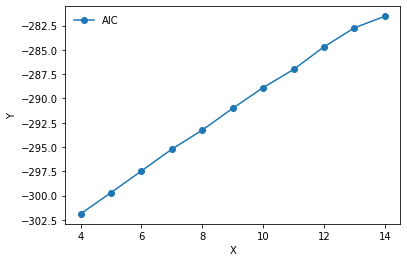

In [221]:
idx = np.arange(4,Pol_Max,1)
plt.plot(idx, AICv,'-o', label='AIC')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='best', frameon=False)
plt.show()

In [222]:
bestGrade = np.argmin(AICv)+4
print(bestGrade)
bestCoef = poly.polyfit(xTrainUno, yTrainUno, bestGrade)
bestPoly = poly.Polynomial(bestCoef)
bestPoly

4


Polynomial([ 6.0000592 ,  8.02956741, -5.99141415, -3.00869471,  1.99588109], domain=[-1,  1], window=[-1,  1])

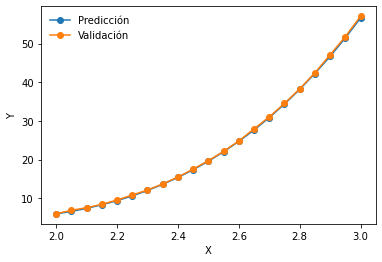

In [223]:
plt.plot(xTestUno, bestPoly(xTestUno),'-o', label='Predicción')
plt.plot(xTestUno, yTestUno,'-o', label='Validación')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='best', frameon=False)
plt.show()

### AIC Lasso 

In [224]:
Pol_Max = 15
RSSv = np.zeros(Pol_Max)
AICv = np.zeros(Pol_Max)

for i in np.arange(0,Pol_Max,1):
    lassoTmp = Lasso(alpha=(i+1)/Pol_Max, max_iter=1e9)
    lassoTmp.fit(dfBuild(xTrainUno), yTrainUno)
    rt, at = getRAP(xTrainUno,yTrainUno,lassoTmp,bestGrade)  
    RSSv[i] = rt
    AICv[i] = at


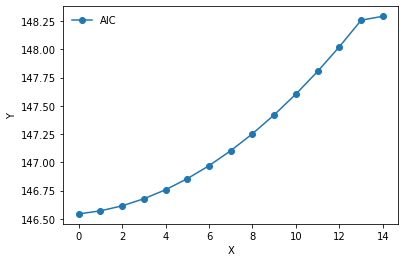

In [225]:
idx = np.arange(0,Pol_Max,1)
plt.plot(idx, AICv,'-o', label='AIC')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend(loc='best', frameon=False)
plt.show()

In [226]:
bestAlpha = (np.argmin(AICv)+1)/Pol_Max
print(bestAlpha)
bestLasso = Lasso(alpha=bestAlpha, max_iter=1e9)
bestLasso.fit(dfBuildIny(xTrainUno,bestGrade), yTrainUno)

0.06666666666666667


Lasso(alpha=0.06666666666666667, max_iter=1000000000.0)

In [292]:
#poly.Polynomial(bestLasso.coef_)
bestLasso.coef_

array([ 7.61825166, -5.28334404, -2.86031312,  1.80518984])

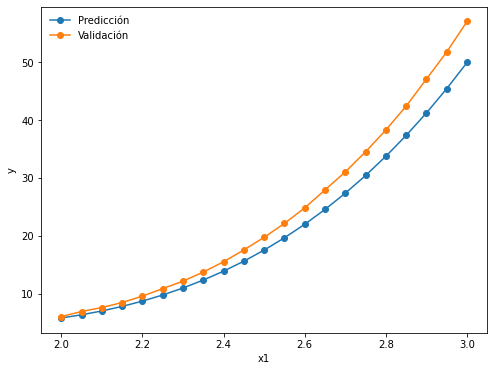

In [228]:
plt.figure(figsize=(8, 6))
plt.plot(xTestUno, bestLasso.predict(dfBuildIny(xTestUno,bestGrade)),'-o', label='Predicción')
plt.plot(xTestUno, yTestUno,'-o', label='Validación')
plt.legend(loc='best', frameon=False)
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

<!-- -->

<!-- -->

<!-- -->

## Punto 2
Creación del operador &(amp) usando una red neuronal secuencial de 3 capas densas. La señal de activación escogida para la capa final es una sigmoidal.


In [82]:
#Tabla de verdad
xTrainAmp = np.array([[0,0],[0,1],[1,0],[1,1]])
yTrainAmp = np.array([[1],[1],[1],[0]])

#Red neuronal, modelo secuencial de 3 capas densa
ampModel = Sequential()
ampModel.add(Dense(15, activation='relu',input_dim=2))
ampModel.add(Dense(15, activation='relu'))
ampModel.add(Dense(15, activation='relu'))
ampModel.add(Dense(1, activation='sigmoid'))
ampModel.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

#Entrenamiento de la red, observe que se desactivaron los mensajes
ampModel.fit(xTrainAmp, yTrainAmp, epochs=2500,verbose=0)
print("Red para & entrenada")

Red para & entrenada


Se imprimen los valores que obtiene la red neuronal luego del entrenamiento, deben 'coincidir' con la tabla de verdad.

In [83]:
ampPredict = ampModel.predict(xTrainAmp)
pd.DataFrame(data={'A&B' : ampPredict.flat})

,A&B
0,0.999982
1,0.999982
2,0.999991
3,0.000018


Creación del operador $(dol) usando una red neuronal secuencial de 3 capas densas. La señal de activación escogida para la capa final es una sigmoidal. 

In [84]:
#Tabla de verdad
xTrainDol = np.array([[0,0],[0,1],[1,0],[1,1]])
yTrainDol = np.array([[0],[0],[0],[1]])

#Red neuronal secuencial densa de 3 capas
dolModel = Sequential()
dolModel.add(Dense(15, activation='relu',input_dim=2))
dolModel.add(Dense(15, activation='relu'))
dolModel.add(Dense(1, activation='sigmoid'))
dolModel.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

#Entrenamiento de la red, observe que se desactivaron los mensajes
dolModel.fit(xTrainDol, yTrainDol, epochs=2500,verbose=0)
print("Red para $ entrenada")

Red para $ entrenada


Se imprimen los valores que obtiene la red neuronal luego del entrenamiento, deben 'coincidir' con la tabla de verdad.

In [85]:
dolPredict = dolModel.predict(xTrainDol)
pd.DataFrame(data={'A$B' : dolPredict.flat})

,A$B
0,0.000011
1,0.000028
2,0.000020
3,0.999970


Cómputo de la operación *(A&B)$C*.

In [86]:
#Representación de las entradas para A&B
A1 = np.array([[1.001,0], [0,1], [0.001,0], [1,1]])
#Cómputo de A&B
amp1 = ampModel.predict(A1)
#Representación de la entrada para (A&B)$C
A2 = np.array([[amp1[0][0],0], [amp1[1][0],1], [amp1[2][0],1], [amp1[3][0],0]])
#Cómputo de (A&B)$C
sol = dolModel.predict(A2)
#Impresión de las tablas
pd.DataFrame(data={ 'A' :  [1.001,0,0.001,1],
                    'B' :  [0,1,0,1],
                    'A&B' : amp1.flat,
                    'C' :  [0,1,1,0], 
                    '(A&B)$C': sol.flat })

,A,B,A&B,C,(A&B)$C
0,1.001,0,0.999991,0,0.000020
1,0.000,1,0.999982,1,0.999970
2,0.001,0,0.999982,1,0.999970
3,1.000,1,0.000018,0,0.000011


<!-- -->


<!-- -->

<!-- -->

## Punto 3
Se hace la lectura de los datos así como la preparación de los mismos. Para este proyecto los datos se encuentran en el archivo *problem3.csv.*

In [177]:
archivoTres = "problem3.csv"
datosTres = pd.read_csv(archivoTres)
datosTres.head(3)

,x_age,x_cholesterol,x_sugar,x_Tcell,y
0,35,220,80,550,0
1,18,240,120,600,0
2,22,260,55,580,0


Gráficas de los datos

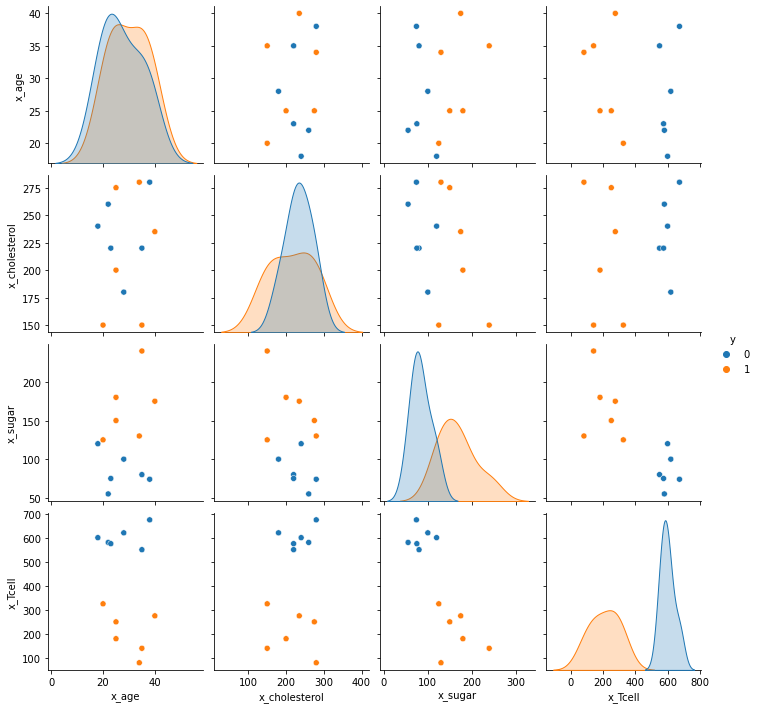

In [178]:
import seaborn as sns
sns.pairplot(datosTres, hue='y', markers='o')
plt.show()

Se imprime una matriz de correlación para poder encontrar las variables que mejor nos separen los datos.

In [179]:
matrizCorrelacion = datosTres.corr(method='spearman')
matrizCorrelacion

,x_age,x_cholesterol,x_sugar,x_Tcell,y
x_age,1.000000,0.141094,0.217545,-0.175440,0.169576
x_cholesterol,0.141094,1.000000,-0.344469,0.126540,-0.169875
x_sugar,0.217545,-0.344469,1.000000,-0.797203,0.869048
x_Tcell,-0.175440,0.126540,-0.797203,1.000000,-0.869048
y,0.169576,-0.169875,0.869048,-0.869048,1.000000


Se gráfica la matriz de correlación.

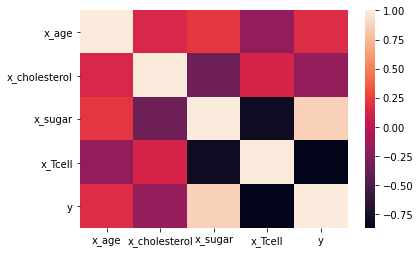

In [180]:
heatMap = sns.heatmap(matrizCorrelacion)
plt.savefig('calor.png', format='png', dpi=800, bbox_inches="tight")

In [231]:
from sklearn.model_selection import train_test_split
xTrainTres, xTestTres, yTrainTres, yTestTres = train_test_split(
    datosTres[['x_age','x_Tcell']], datosTres['y'], test_size=0.2, random_state= 50)
xTrainTres.head()

,x_age,x_Tcell
3,23,575
2,22,580
7,25,180
5,38,674
6,40,275


Construcción del modelo de clasificación, se usa una red neuronal secuencial densa de 3 capas.

In [232]:
def classification_model():
    model = Sequential()
    model.add(Dense(8, activation='relu', input_shape=(2,)))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    #model.compile(Adam(lr=0.04),'categorical_crossentropy',metrics=['accuracy'])
    return model

Se instancia la red neuronal

In [233]:
#Observe que se desactivaron los mensajes de Keras
classifier = KerasClassifier(build_fn = classification_model, 
                             epochs=200, batch_size=20, verbose=0)

In [234]:
num_classes = 2
kfold = KFold(n_splits=5, shuffle=True, random_state=50)
results = cross_val_score(classifier, xTrainTres, yTrainTres, cv = kfold)
print("Rendimiento del modelo: Media: %.3f%% std: (%.2f%%)" % (results.mean()*100, results.std()*100))

ValueError: in user code:

    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1233 test_function  *
        return step_function(self, iterator)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /usr/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1217 run_step  **
        outputs = model.test_step(data)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1185 test_step
        self.compiled_loss(
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /usr/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /usr/lib/python3.9/site-packages/tensorflow/python/keras/backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /usr/lib/python3.9/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 2) are incompatible


In [235]:
model = classification_model()
model.fit(xTrainTres, to_categorical(yTrainTres), epochs=200, verbose=0)
scores = model.evaluate(xTestTres,to_categorical(yTestTres))
print('Accuracy: {}% \n Error: {}'.format(scores[1], 1 - scores[1]))   

1/1 [==============================] - 0s 253ms/step - loss: 0.1801 - accuracy: 1.0000
Accuracy: 1.0% 
 Error: 0.0


<!-- --> 

<!-- -->

<!-- -->

## Punto 4
Se generan 500 puntos aleatorios para generar los datos de entrenamiento.

In [143]:
trainSize = 500
xTrainCuatro = randn(trainSize)
yTrainCuatro = randn(trainSize)

Se define el cono, $\frac{x^{2}}{2} + \frac{y^{2}}{2} = z^{2}$.

In [144]:
def Cono(x,y):
    return x**2 + y**2

A partir de los puntos (x,y) se generan los puntos z.

In [145]:
zTrainCuatro = Cono(xTrainCuatro,yTrainCuatro)


Construcción del DataFrame con los datos (x,y).

In [146]:
trainCuatro = pd.DataFrame({'x': xTrainCuatro, 'y': yTrainCuatro})
trainCuatro.head(3)

,x,y
0,-0.611570,-0.316838
1,0.294143,-1.488147
2,0.065687,1.481625


Se crea la red neuronal, secuencial densa de 3 capas con 2 variables de entrada.

In [147]:
redCono = Sequential()
redCono.add(Dense(16, activation='relu', input_shape=(2,)))
redCono.add(Dense(16, activation='relu'))
redCono.add(Dense(16, activation='relu'))
redCono.add(Dense(16, activation='relu'))
redCono.add(Dense(1, activation='relu'))
    
redCono.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

Entrenamiento de la red neuronal

In [148]:
resultadosCono = redCono.fit( trainCuatro,  zTrainCuatro, 
                       validation_split=0.3, epochs=500, verbose=0)
print("Red para el Cono entrenada")

Red para el Cono entrenada


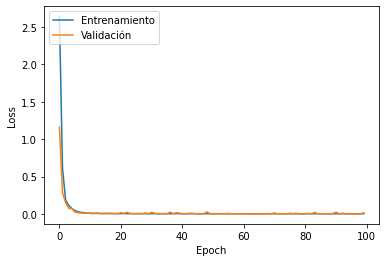

In [149]:
plt.plot(resultadosCono.history['loss'])
plt.plot(resultadosCono.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

Se define el tamaño de los datos de validación y se generan los puntos para la validación.

In [150]:
testSize = 50000
xTestCuatro = randn(testSize)
yTestCuatro = randn(testSize)
testCuatro = pd.DataFrame({'x': xTestCuatro, 'y': yTestCuatro})
testCuatro.head()

,x,y
0,0.670876,-0.459664
1,1.597810,-1.327745
2,0.308663,0.972154
3,0.629599,0.209322
4,0.979841,-0.682118


In [151]:
test_mse_score, test_mae_score = redCono.evaluate(
    testCuatro, Cono(xTestCuatro,yTestCuatro))
test_mae_score

15625/15625 [==============================] - 53s 3ms/step - loss: 0.0170 - mae: 0.0813


0.08133058249950409

Se generan las predicciones para el conjunto de datos de validación.

In [152]:
prediccionesCono = redCono.predict(testCuatro)

Se grafican los datos reales versus los predecidos.

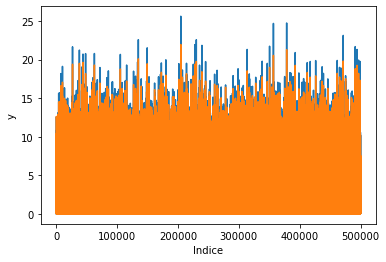

In [153]:
plt.plot(np.arange(testSize),Cono(xTestCuatro,yTestCuatro))
plt.plot(np.arange(testSize),prediccionesCono)
plt.ylabel('y')
plt.xlabel('Indice')
plt.show()

Se dibuja el cono con los datos predecidos.

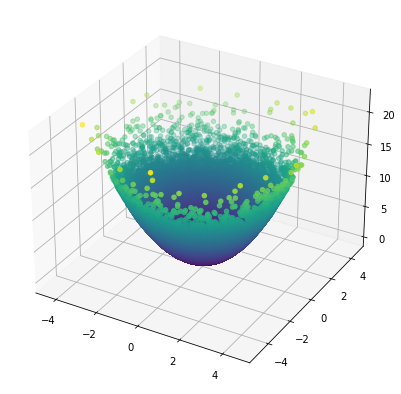

In [154]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot( projection='3d')
ax.scatter(xTestCuatro,yTestCuatro,prediccionesCono,c=prediccionesCono)
plt.show()



<!-- --> 

<!-- --> 

<!-- --> 

<!-- --> 